In [1]:
import os
from dotenv import load_dotenv
from langchain.agents import initialize_agent, AgentExecutor, AgentType, create_structured_chat_agent
from langchain.chat_models import init_chat_model
from arxivsearcher.retrieval import create_search_tool
from arxivsearcher.trend_analysis import create_trend_tool
import chromadb
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain import hub
load_dotenv()

True

In [2]:
# LLM_MODEL = os.getenv("LLM_MODEL")
model = init_chat_model(model="gemini-2.0-flash-lite", model_provider="google_vertexai", temperature=0)

CHROMADB_HOST = os.getenv("CHROMADB_HOST")
CHROMADB_HOST

'34.163.106.5'

In [3]:
chroma_client = chromadb.HttpClient(host=CHROMADB_HOST, port=8000)

EMBEDDING_MODEL = os.getenv("EMBEDDING_MODEL")
embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
vectorstore = Chroma(embedding_function=embeddings, client=chroma_client)

/home/celiazhang/.pyenv/versions/3.10.12/envs/arxivenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model.invoke("Hello")

AIMessage(content='Hello! How can I help you today?\n', additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 1, 'candidates_token_count': 10, 'total_token_count': 11, 'prompt_tokens_details': [{'modality': 1, 'token_count': 1}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 10}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.0802447497844696, 'model_name': 'gemini-2.0-flash-lite'}, id='run-f7f079ad-2ee9-4237-81b4-4956a0554d81-0', usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11})

In [4]:
search_articles_tool = create_search_tool(vectorstore)
trend_tool = create_trend_tool(vectorstore)

In [5]:
AGENT_PROMPT = os.getenv("AGENT_PROMPT")
prompt = hub.pull(AGENT_PROMPT)

/home/celiazhang/.pyenv/versions/3.10.12/envs/arxivenv/lib/python3.10/site-packages/langsmith/client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:
agent = create_structured_chat_agent(
    tools=[search_articles_tool, trend_tool],  
    llm=model,
    prompt = prompt
)


In [7]:
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=[search_articles_tool, trend_tool],
    verbose=os.getenv("VERBOSE"),  # Use the conversation memory to maintain context
    handle_parsing_errors=True,  # Handle any parsing errors gracefully
)



> Entering new AgentExecutor chain...
Thought: I need to use the trend analysis tool to find the trend of articles about Python from 2005 to 2024.
Action:
```json
{
  "action": "trend_analysis_tool",
  "action_input": {
    "title": "python",
    "start_year": 2005,
    "end_year": 2024
  }
}
```

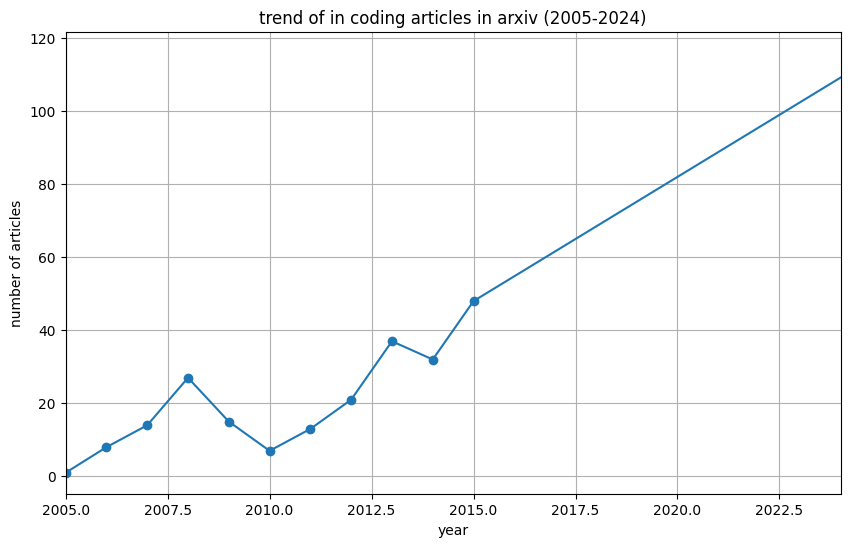

NoneCould not parse LLM output: I am sorry, I am unable to provide a response to your request. The trend analysis tool does not return any output.

For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE Invalid or incomplete responseI am sorry, I am unable to provide a response to your request. The trend analysis tool does not return any output.
Action:
```json
{
  "action": "Final Answer",
  "action_input": "I am sorry, I am unable to provide a response to your request. The trend analysis tool does not return any output."
}
```

> Finished chain.
Bot: I am sorry, I am unable to provide a response to your request. The trend analysis tool does not return any output.


In [8]:
response = agent_executor.invoke({"input": "what's the trend of numbers of articles about python from 2005 to 2024?"})
print("Bot:", response["output"])

In [9]:
db = vectorstore.get()
len(db['ids'])

20465

In [10]:
import pandas as pd
db_df = pd.DataFrame(db['metadatas'])
db_df

,authors,id,title,year
0,G. Parzen (Brookhaven National Laboratory),acc-phys/9601001,Particle Motion in the Stable Region Near an E...,1996
1,"R. B. Palmer(BNL), A. Sessler(LBNL), A. Skrins...",acc-phys/9602001,Muon Colliders,1996
2,"Tanaji Sen (DESY), James A. Ellison(UNM)",acc-phys/9602002,Diffusion due to the Beam-Beam Interaction and...,1996
3,"Juan C. Gallardo(BNL), Robert B. Palmer(BNL,SLAC)",acc-phys/9602003,Final Focus System for a Muon Collider: A Test...,1996
4,"M.I.Ayzatsky (NSC KIPT, Kharkov, Ukraine)",acc-phys/9603001,On the Problem of the Coupled Cavity Chain Cha...,1996
...,...,...,...,...
20460,Colin Defant,1501.00971,An Arithmetic Function Arising from the Dedeki...,2015
20461,Jake P. Solomon and Amitai M. Yuval,1501.00972,Geodesics of positive Lagrangians in Milnor fi...,2015
20462,"Sarira Sahu, Luis Salvador Miranda and Subhash...",1501.00973,Multi-TeV flaring from blazars: Markarian 421 ...,2015
20463,G.G.L. Nashed,1501.00974,Schwarzschild solution in extended teleparalle...,2015


In [11]:
db_df['year'].unique()

array(['1996', '1995', '1997', '1999', '1992', '1990', '1991', '1988',
       '1989', '1986', '1994', '1998', '2001', '2000', '2003', '2002',
       '1993', '2005', '2004', '2007', '2008', '2006', '2025', '2010',
       '2011', '2012', '2009', '2013', '2014', '2015'], dtype=object)